In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import make_scorer
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Bike Sharing Demand

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. 

* file format: CSV
* File Capacity: 634 KB

**Objective**

You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

**Data Fields**
* datetime - hourly date + timestamp  
* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather - 
     * 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
     * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
     * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
     * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals

## Load Dataset

In [3]:
train = pd.read_csv('train.csv', parse_dates=['datetime'])

print(train.shape)
train.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [4]:
test = pd.read_csv('test.csv', parse_dates=['datetime'])
print(test.shape)
test.head(3)

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000


## Explore

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.6 KB


### Explore datetime

In [6]:
train['date-year'] = train['datetime'].dt.year
train['date-month'] = train['datetime'].dt.month
train['date-day'] = train['datetime'].dt.day
train['date-hour'] = train['datetime'].dt.hour
train['date-minute'] = train['datetime'].dt.minute
train['date-second'] = train['datetime'].dt.second

print(train.shape)
train[['datetime','date-year','date-month','date-day','date-hour','date-minute',
      'date-second']].head()

(10886, 18)


,datetime,date-year,date-month,date-day,date-hour,date-minute,date-second
0,2011-01-01 00:00:00,2011,1,1,0,0,0
1,2011-01-01 01:00:00,2011,1,1,1,0,0
2,2011-01-01 02:00:00,2011,1,1,2,0,0
3,2011-01-01 03:00:00,2011,1,1,3,0,0
4,2011-01-01 04:00:00,2011,1,1,4,0,0


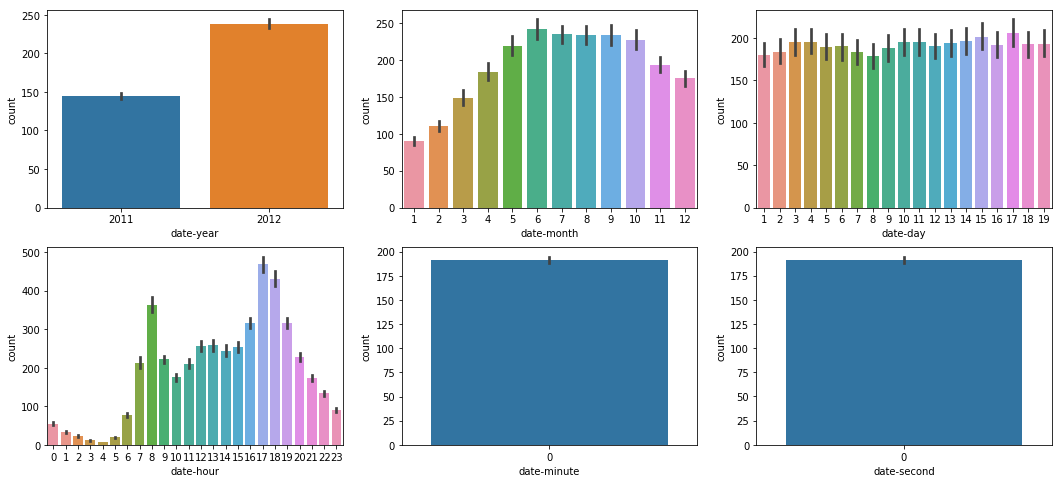

In [7]:
# fig, ax = plt.subplots() is equal to 
# fig = plt.figure() and
# ax = fig.add_subplot(111) combined

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(nrows=2,ncols=3)
fig.set_size_inches(18,8)
sns.barplot(data=train, x='date-year', y='count',ax=ax1)
sns.barplot(data=train, x='date-month', y='count',ax=ax2)
sns.barplot(data=train, x='date-day', y='count',ax=ax3)
sns.barplot(data=train, x='date-hour', y='count',ax=ax4)
sns.barplot(data=train, x='date-minute', y='count',ax=ax5)
sns.barplot(data=train, x='date-second', y='count',ax=ax6)

**Findings**
   *  **minute** and **second** is not recorded in the data. Thus, no need to use these features.
   * Since **day** is what separates the train and test data, it should not be used as a feature.

### Explore hour - workingday 

In [8]:
train['workingday'].value_counts()

1    7412
0    3474
Name: workingday, dtype: int64

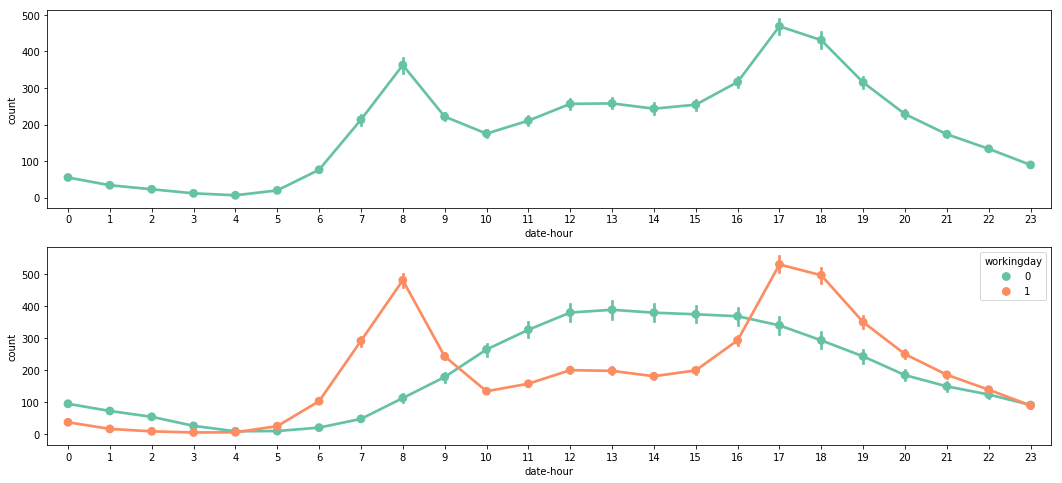

In [9]:
fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1)
fig.set_size_inches(18,8)

sns.set_palette('Set2') 
sns.pointplot(data=train,x='date-hour',y='count',ax=ax1)
sns.pointplot(data=train,x='date-hour',y='count',hue='workingday',ax=ax2)

**Findings**
   * Because there are more workdays than weekends, separating these two are important.
   * Counts are high at 8am and 5pm in workday.
   * Counts are up in the afternoons on weekends.

### Explore hour - dayofweek

In [10]:
train['date-dayofweek'] = train['datetime'].dt.dayofweek

print(train.shape)
train[['datetime','date-dayofweek']].head()

(10886, 19)


,datetime,date-dayofweek
0,2011-01-01 00:00:00,5
1,2011-01-01 01:00:00,5
2,2011-01-01 02:00:00,5
3,2011-01-01 03:00:00,5
4,2011-01-01 04:00:00,5


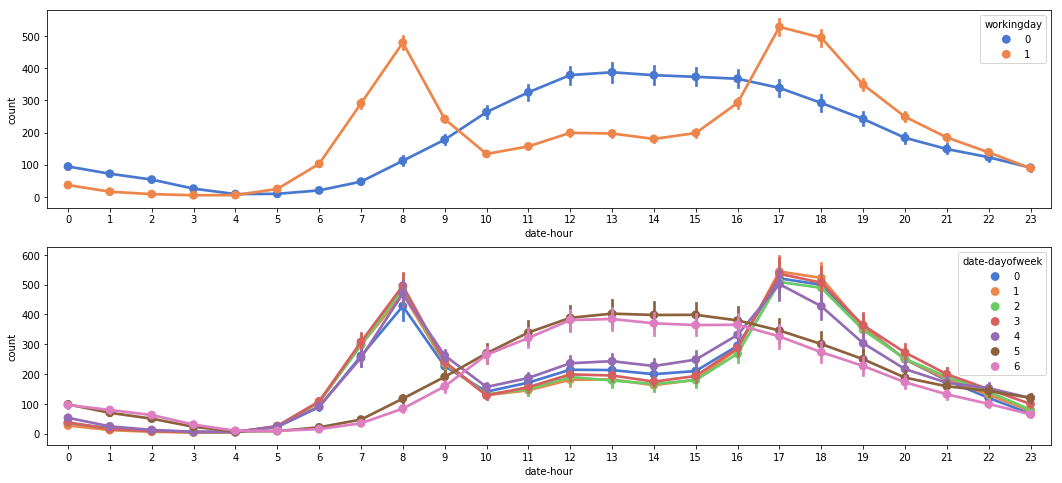

In [11]:
fig, (ax1,ax2) = plt.subplots(nrows = 2,ncols = 1)
fig.set_size_inches(18,8)

sns.set_palette('muted')
sns.pointplot(data=train, x = 'date-hour', y='count',hue='workingday',ax=ax1)
sns.pointplot(data=train, x = 'date-hour', y='count',hue='date-dayofweek',ax=ax2)

# Monday = 0, Sunday = 6

**Findings**
   * Friday(workingday = 4) and Monday(workingday = 0) show a slight resemblence to weekends' plot.
   * Reason for this could be because people tend to take days off on mondays or fridays.

### Concatenate year and month

In [12]:
def concatenate_year_month(datetime):
    return '{0}-{1}' .format(datetime.year, datetime.month)

train['date-year_month'] = train['datetime'].apply(concatenate_year_month)

print(train.shape)
train[['datetime','date-year_month']].head()

(10886, 20)


,datetime,date-year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


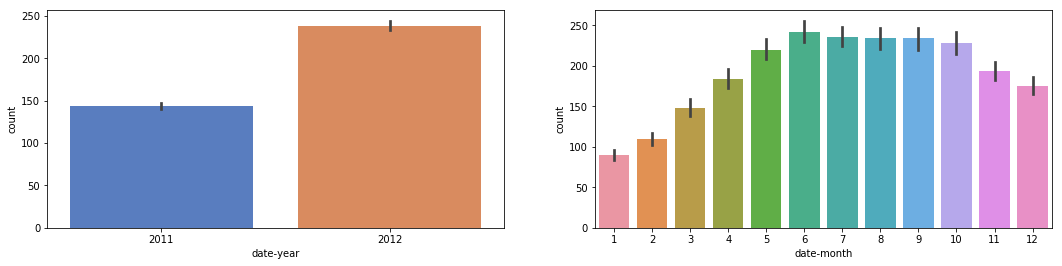

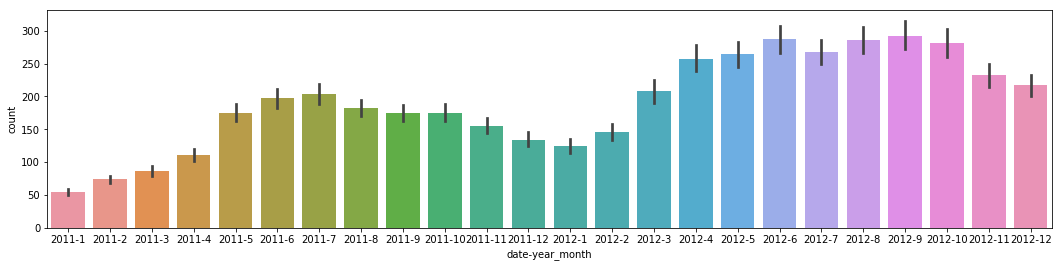

In [13]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18,4)

sns.barplot(data=train, x = 'date-year',y = 'count',ax=ax1)
sns.barplot(data=train, x = 'date-month', y = 'count', ax=ax2)

fig, ax3 = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(18,4)

sns.barplot(data=train, x = 'date-year_month', y = 'count', ax=ax3)

**Findings**
   * 2011-12 and 2012-1 show similar numbers of rentals, which cannot be seen when year is not separated.
   * In 2011, numbers keep decreasing since August. (grammar?)

## Reload Dataset

In [14]:
train = pd.read_csv("train.csv", parse_dates=["datetime"])
                    
print(train.shape)
train.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


## Preprocessing

### Parse datetime

In [15]:
train["date-year"] = train["datetime"].dt.year
train["date-month"] = train["datetime"].dt.month
train["date-day"] = train["datetime"].dt.day
train["date-hour"] = train["datetime"].dt.hour
train["date-minute"] = train["datetime"].dt.minute
train["date-second"] = train["datetime"].dt.second
train["date-dayofweek"] = train["datetime"].dt.dayofweek

print(train.shape)
train[["datetime", "date-year", "date-month", "date-day", 
       "date-hour", "date-dayofweek"]].head()

(10886, 19)


,datetime,date-year,date-month,date-day,date-hour,date-dayofweek
0,2011-01-01 00:00:00,2011,1,1,0,5
1,2011-01-01 01:00:00,2011,1,1,1,5
2,2011-01-01 02:00:00,2011,1,1,2,5
3,2011-01-01 03:00:00,2011,1,1,3,5
4,2011-01-01 04:00:00,2011,1,1,4,5


In [16]:
test["date-year"] = test["datetime"].dt.year
test["date-month"] = test["datetime"].dt.month
test["date-day"] = test["datetime"].dt.day
test["date-hour"] = test["datetime"].dt.hour
test["date-minute"] = test["datetime"].dt.minute
test["date-second"] = test["datetime"].dt.second
test["date-dayofweek"] = test["datetime"].dt.dayofweek

print(test.shape)
test[["datetime", "date-year", "date-month", "date-day", 
       "date-hour", "date-dayofweek"]].head()

(6493, 16)


,datetime,date-year,date-month,date-day,date-hour,date-dayofweek
0,2011-01-20 00:00:00,2011,1,20,0,3
1,2011-01-20 01:00:00,2011,1,20,1,3
2,2011-01-20 02:00:00,2011,1,20,2,3
3,2011-01-20 03:00:00,2011,1,20,3,3
4,2011-01-20 04:00:00,2011,1,20,4,3


## Train

In [17]:
train.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date-year,date-month,date-day,date-hour,date-minute,date-second,date-dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0,5


* season - 1 = spring, 2 = summer, 3 = fall, 4 = winter
* weather -
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog


In [18]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'date-year', 'date-month', 'date-day', 'date-hour', 'date-minute',
       'date-second', 'date-dayofweek'],
      dtype='object')

In [19]:
feature_names = ['season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed','date-year','date-hour','date-dayofweek']

In [20]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,date-year,date-hour,date-dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,2011,0,5
1,1,0,0,1,9.02,13.635,80,0.0,2011,1,5
2,1,0,0,1,9.02,13.635,80,0.0,2011,2,5
3,1,0,0,1,9.84,14.395,75,0.0,2011,3,5
4,1,0,0,1,9.84,14.395,75,0.0,2011,4,5


In [21]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,date-year,date-hour,date-dayofweek
0,1,0,1,1,10.66,11.365,56,26.0027,2011,0,3
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,3
2,1,0,1,1,10.66,13.635,56,0.0000,2011,2,3
3,1,0,1,1,10.66,12.880,56,11.0014,2011,3,3
4,1,0,1,1,10.66,12.880,56,11.0014,2011,4,3


In [22]:
y_train = train['count']

print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [23]:
y_train = np.log(y_train + 1)

print(y_train.shape)
y_train.head()

(10886,)


0    2.833213
1    3.713572
2    3.496508
3    2.639057
4    0.693147
Name: count, dtype: float64

In [24]:
def rmsle(predict, actual):
    predict = np.array(predict)
    actual = np.array(actual)
    
    log_predict = np.log(predict + 1)
    log_actual = np.log(actual + 1)
    
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    mean_difference = difference.mean()
    
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

## Hyperparameter Tuning

### Random Search

### Random Search(Finer Search)

In [27]:
hyperparameters_list = []

n_estimators = 600
num_epoch = 5

for epoch in range(num_epoch):
    max_depth = np.random.randint(low = 30, high = 90)
    max_features = np.random.uniform(low = 0.4, high = 1.0)
    
    model = RandomForestRegressor( n_estimators = n_estimators,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 random_state = 42, n_jobs = -1)
    
    score = cross_val_score(model, X_train, y_train, cv = 20,
                           scoring = rmsle_scorer).mean()
    
    hyperparameters_list.append({
        'score': score, 'max_depth': max_depth, 'max_features': max_features
    })
    
    print('Score = {0: .5f}, depth:{1}, features:{2}' .format(score,max_depth,max_features))
    
hyperparameters_list = pd.DataFrame.from_dict(hyperparameters_list)
hyperparameters_list = hyperparameters_list.sort_values(by='score')

print(hyperparameters_list.shape)
hyperparameters_list.head()

Score =  0.08795, depth:45, features:0.8713404281513941
Score =  0.09115, depth:30, features:0.5413000447085259
Score =  0.08826, depth:38, features:0.983918666873831
Score =  0.08902, depth:86, features:0.6302997397250081
Score =  0.08800, depth:34, features:0.7360258117947289
(5, 3)


,max_depth,max_features,score
0,45,0.871340,0.087945
4,34,0.736026,0.087999
2,38,0.983919,0.088261
3,86,0.630300,0.089022
1,30,0.541300,0.091154


In [28]:
model = RandomForestRegressor(n_estimators = 600,
                              max_depth = 88,
                              max_features = 0.8231768,
                              random_state = 42,
                              n_jobs = -1
                             )
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=88,
           max_features=0.8231768, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

## Train

In [29]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=88,
           max_features=0.8231768, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [30]:
predictions = model.predict(X_test)

predictions = np.exp(predictions) - 1

print(predictions.shape)
predictions

(6493,)


array([ 11.38566219,   4.80476655,   3.26711175, ..., 100.05803296,
        97.59568733,  45.90319578])

In [33]:
ft_importance = pd.DataFrame(model.feature_importances_, index = X_train.columns,
                             columns = ['importance']).sort_values('importance', ascending=False)
ft_importance

,importance
date-hour,0.744025
temp,0.043937
atemp,0.039395
workingday,0.032413
date-year,0.031695
season,0.031636
date-dayofweek,0.031386
humidity,0.021903
weather,0.011336
windspeed,0.010596
